In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using Plots
using Colors
using IterTools
Threads.nthreads()


(process:19968): GLib-GIO-WARNING **: 16:55:54.574: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_19.0.3.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [130]:
function assembly(T,J,N,N²)
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs etradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end
    return Λ
end

function hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M)
    # BLOC EXTRA-DIAGONAL 
    J = -1/(2*M*δR²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+1/(M*δR²))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = - SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²)
    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(Δd², N, V, m)
    Λ = -1/(Δd²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = Diagonal(V); # V_fun.(LinRange(r_min,r_max,N)) pour créer l'argument
    H = Λ + V; 
    H, Λ, V
end



function hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V, m, ϵ², K)
    # BLOC EXTRA-DIAGONAL 
    J = -K*ϵ²/(2*δu²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*δr²)+K*ϵ²/δu²)*ones(Float64,N); # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*δr²)*ones(Float64,N-1);     # vecteur de la sur- et sous-diagonale remplies de 1
    T = - SymTridiagonal(diag, extra_diag);    # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = assembly(T,J,N,N²);
    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ + V;
    H, Λ, V # opérateurs (matrices de taille N²×N²)
end


hamiltonian_2D_rescaled (generic function with 1 method)

In [173]:
function decompose_hamiltonian_rescaled(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, M, kdim)
    δr = (r_max-r_min)/(N-1);
    δR = (R_max-R_min)/(N-1);
    δr² = δr*δr;
    δR² = δR*δR;
    N² = N*N;


    # CONSTRUCTION DE LA MESHGRID
    rs = Vector(r_min:δr:r_max); # direction coordonnée électron
    Rs = Vector(R_min:δR:R_max); # direction coordonnée distance noyau-noyau
    rg = ones(N)' .* rs;
    Rg = Rs' .* ones(N);
    V = zeros(N,N);


    # CONSTRUCTION DU POTENTIEL ORIGINAL ET DU HAMILTONIEN SUR GRILLE paramétré en R
    V = @. V_nucl_el(rg, Rg) + V_nucl_nucl(Rg); # potentiel d'interaction sur la grille tous phénomènes compris
    Ĥ, Λ, V̂ = hamiltonian_2D(δr, δr², δR, δR², N, N², V, m, M);
    lowest_energies_y = zeros(N);



    # STRUCTURE DU LAPLACIEN 1D
    LS = SymTridiagonal(-2*ones(Float64,N), ones(Float64,N-1)); 

    # LAPLACIENS SUR AXES
    Λr = -1/(δr²*2*m)*LS;  # laplacien sur l'axe r
    ΛR = -1/(δR²*2*M)*LS;  # laplacien sur l'axe R


    # à changer pour faire une dichotomie ou une biblithèque d'optimisation
    # RECHERCHE DU R₀  minimisant l'énergie de l'état fondamental
    lE₀ = zeros(N);
    Base.Threads.@threads for j in 1:N
        Vx = sparse(Diagonal(Vector(V_nucl_el.(rs,R_min+j*δR)))) # potentiel en x à R=jδR fixé (i.e. à distance noyau-noyau fixé)
        vals, ~, infos = KrylovKit.eigsolve(Λr+Vx, N, 1, :SR, krylovdim=kdim);
        @assert infos.converged > 0;
        lE₀[j]     = infos.converged>=1 ? vals[1] + V_nucl_nucl(R_min + j*δR)  : NaN;
        # on récupère l'énergie  propre du niveau fondamental sur la tranche à R fixé
    end  


    # CALCUL DU R₀ ET DES RAIDEURS
    E₀_at_R₀, ind_R₀ = findmin(lE₀);       # trouver l'énergie de surface minimale
    R₀               = ind_R₀*δR + R_min;  # définir le paramètre nucléaire minimisant l'énergie de surface
    K = 1/(δR)^2 * dot([−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560], view(lE₀, ind_R₀-4:ind_R₀+4));  # on calcule la dérivée seconde  à l'ordre 8 par rapport à y de E₀ en R₀
    # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturbé
    
    ϵ = 1/sqrt(sqrt(K*M)); # paramètre de redimensionnement
    ϵ² = ϵ^2;


    # NOUVEAUX PARAMETRES SUR AXE avec rescaling
    u_min = 1/ϵ*(R_min-R₀);
    u_max = 1/ϵ*(R_max-R₀);
    δu = (u_max-u_min)/(N-1);
    δu² = δu^2;
    us = Vector(u_min:δu:u_max);
    ug = us' .* ones(N); # équivalent de Y: sur la grille donne (r,u) ↦ u
    Λu = -1/ϵ^2/δu²*LS; # laplacien sur l'axe (Ou)


    # FONCTIONS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS  
    V₀r  = V[:,ind_R₀];          # formule 3.19 rapport sans la constante .- E₀_at_R₀
    V₀R  = .5*K*(Rs.-R₀).^2;     # formule 3.19 rapport sans la constante .+ E₀_at_R₀, équivaut à V₀u


    # OPÉRATEURS POTENTIELS NON PERTURBÉS SUR AXES SÉPARÉS 
    V̂⁰r  = Diagonal(V₀r);
    V̂⁰R  = Diagonal(V₀R);


    # HAMILTONIENS NON PERTURBÉS SUR AXES SÉPARÉS
    Ĥ⁰r  = Λr + V̂⁰r;
    Ĥ⁰R  = ΛR + V̂⁰R;
    Ĥ⁰u  = Λu + V̂⁰R;


    # FONCTION POTENTIEL HBO NON PERTURBÉ SUR GRILLE
    # formule 3.19: somme des deux premières lignes en potentiel:
    V₀ = @. V[:,ind_R₀]*ones(N)'    + .5*K*    (Rg.-R₀).^2; # (r,R) ↦ V(r,R₀) + 1/2*(∂²E₀/∂R²)(R₀)(R-R₀)²
    # même tableau pour (r,u) ↦ V(r,u₀) + ϵ²/2*(∂²E₀/∂u²)(u₀)(u-u₀)²


    # OPÉRATEUR POTENTIEL NON PERTURBÉ SUR GRILLE
    V̂⁰ = Diagonal(reshape(V₀, N²));


    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN NON PERTURBÉS HBO SUR GRILLE
    Ĥ⁰ = Λ + V̂⁰; # avec paramétrage R

    # FONCTION PERTURBATION Vp (développement de Taylor de la perturbation)
    # ordre 1 en espace: (∂V/∂R)(r,R₀)×(R-R₀)
    ∂R_of_V_at_rR₀   = 1/δR*  V[:,ind_R₀-4:ind_R₀+4] * [1/280 −4/105 1/5 −4/5 0. 4/5 −1/5 4/105 −1/280]';       # vecteur contenant ∂V/∂R(r,R₀) pour tous les r
    V₁               = ∂R_of_V_at_rR₀*ones(N)' .* (Rg.-R₀);                  # on le transforme en grille



    # ordre 2 en espace: 1/2×[(∂²V/∂R²)(r,R₀) - d²E₀/dR²(R₀)](R-R₀)² 
    ∂²RR_of_V_at_rR₀ = 1/δR²* V[:,ind_R₀-4:ind_R₀+4] * [−1/560 8/315 −1/5 8/5 −205/72 8/5 −1/5 8/315 −1/560]';       # vecteur contenant ∂²V/∂R²(r,R₀) pour tous les r
    ∂²uu_of_V_at_ru₀ = ϵ^2*∂²RR_of_V_at_rR₀;
    V₂               = .5*(∂²RR_of_V_at_rR₀*ones(N)' .- K) .* (Rg.-R₀).^2; # on le transforme en grille


    # perturbation totale ordre 1 + ordre 2 en espace (so far)
    Vp = V₁ + V₂;

    # OPÉRATEUR PERTURBATION paramétré en R
    Ŵ  = Diagonal(reshape(Vp, N²)); # ψ∈L²(ℝ^N²) ↦ Vp×ψ

    # OPÉRATEURS RESCALED cf doc Éric
    V_res = @. V_nucl_el(rg, R₀.+ϵ*ug) + V_nucl_nucl(R₀.+ϵ*ug); # (r,u) ↦ V(r,u)



    # OPÉRATEUR RESCALÉ ORIGINAL SUR GRILLE
    𝔥,~,~  = hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V_res, m, ϵ², K) # 𝔥 : Ψ(r,u) ∈ L²(ℝ^N^2) ↦ -1/2m × ∂²/∂r² -1/2M × ∂²/∂u² + V(r,u) le hamiltonien original complet
    
    # OPÉRATEURS HAMILTONIENS NON PERTURBÉS RESCALÉS SUR AXES SÉPARÉS
    𝔥u =   K*ϵ²*(-1/2/δu²*LS + 1/2*sparse(Diagonal(us.^2)));  # 𝔥u : ψ(u) ∈ L²(ℝ^N) ↦ 1/2 × Kϵ²(-∂²/∂u² + u²)ψ pour la solution-produit tensoriel
    𝔥r = - 1/2*Λr + V̂⁰r;                                      # 𝔥r : ψ(r) ∈ L²(ℝ^N) ↦ 1/2 ×    (-∂²/∂r² + R²)ψ pour la solution-produit tensoriel
    # Voir si on peut virer le sparse (SymTriDiagonal supporté par KrylovKit ?)
    

    𝔳   = @. (V_nucl_el(rg, R₀) + V_nucl_nucl(Rg)) + 1/2*ϵ²*K*ug.^2;
    𝔴  =  V  - 𝔳; # ψ(r,u) ∈ L²(ℝ^N²) ↦ perturbation formule à FINIR
    Ŵu = Diagonal(reshape(𝔴,N²));
    
    𝔥₀,~,~  = hamiltonian_2D_rescaled(δr, δr², δu, δu², N, N², V₀, m, ϵ², K);
    
    return Λ, Ĥ, V̂, V,
           Ĥ⁰, V̂⁰, V₀,
           Ĥ⁰r, Ĥ⁰R, V̂⁰r, V̂⁰R, V₀r, V₀R,
           Ŵ, Vp, V₁, V₂,
           lE₀, ind_R₀, R₀, E₀_at_R₀,
           δr, δR, rs, Rs,
           K, ∂²RR_of_V_at_rR₀, ∂R_of_V_at_rR₀,
           Λu, u_min, u_max, δu, δu², us, V̂⁰_res, Λ_res, V_res,
           Ĥ⁰u, Λu, ϵ, 𝔥, 𝔥₀, 𝔥u, 𝔥r, 𝔴, Ŵu

end

decompose_hamiltonian_rescaled (generic function with 1 method)

### 1) Création d'un problème avec un potentiel

In [165]:

me = 1; mp = 1000;
M=(2*mp^3+mp^2*me)/(2*mp*(me+mp));
m=(2*mp^2*me)/(mp*(2*mp+me)); 
r_min=-5.; r_max=5.; R_min=0.0; R_max=3.5; N=80; ω=1.; kdim=30; # augmenter la dimension Krylov quand N est grand: pour N=200, prendre kdim=50
β=1.5; η=.5; V0=1.5; σ=1.;


function V_nucl_el(r,R)
     return -V0*( exp(-(r-R/2)^2/2/σ^2) + exp(-(r+R/2)^2/2/σ^2) ) # potentiels interaction électron avec les 2 noyaux
end

function V_nucl_nucl(R)
     return + β/sqrt(η^2+R^2) # potentiel interaction des 2 noyaux entre eux
end

V_nucl_nucl (generic function with 1 method)

### 2) Décomposition (approchée) d'un hamiltonien perturbé $H_0$ et d'une correction $\hat{W}$.
Remarque: lorsqu'on plot une heatmap d'une matrice avec l'axe des $x$ indicé $i$ et l'axe $y$ indicé $j$, on doit transposer car https://discourse.julialang.org/t/hi-evrybody-im-trying-to-overlay-a-scatter-plot-with-a-heatmap-using-plots-jl-bu/56067

  0.548146 seconds (957.39 k allocations: 65.681 MiB, 3.69% gc time, 57.42% compilation time)
ky=0.5373
R₀=1.6392
E₀(R₀)=-0.84


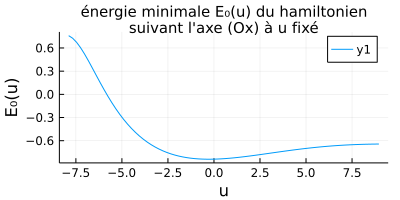

In [174]:
# 1 min pour 400 par 400, 20 sec pour 300 par 300
@time   Λ,                            # laplacien 2D commun
        Ĥ,   V̂,   V,                  # opérateurs et potentiel 2D originaux
        Ĥ⁰,  V̂⁰,  V₀,                 # hamiltonien et potentiel 2D non perturbés
        Ĥ⁰r, Ĥ⁰R, V̂⁰r, V̂⁰R, V₀r, V₀R, # opérateurs et potentiels 1D non perturbés
        Ŵ,   Vp,  V₁,  V₂,            # hamiltonien et potentiel de la perturbation et sa décomposition
        lE₀, ind_R₀, R₀, E₀_at_R₀,    # liste des énergies sur Ox en fonction de y et minimum R₀
        δr, δR, rs, Rs,               # paramètres du problème
        K, ∂²RR_of_V_at_rR₀, ∂R_of_V_at_rR₀,
        Λu, u_min, u_max, δu, δu², us, V̂⁰_res, Λ_res, V_res,
        Ĥ⁰u, Λu, ϵ, 𝔥, 𝔥₀, 𝔥u, 𝔥r, 𝔴, Ŵu  = decompose_hamiltonian_rescaled(r_min, r_max, R_min, R_max, N, V_nucl_el, V_nucl_nucl, m, M, kdim);
        

println("ky=$(round(K,digits=4))\nR₀=$(round(R₀,digits=4))\nE₀(R₀)=$(round(lE₀[ind_R₀],digits=3))")
# @show isposdef(Ĥ)
plot(us, lE₀, title="énergie minimale E₀(u) du hamiltonien\nsuivant l'axe (Ox) à u fixé", xlabel="u", ylabel="E₀(u)", size=(400,200), titlefontsize=10)
# plot(Rs,lE₀, title="énergie minimale E₀(R) du hamiltonien\nsuivant l'axe (Ox) à R fixé", xlabel="R", ylabel="E₀(R)", size=(400,200), titlefontsize=10)

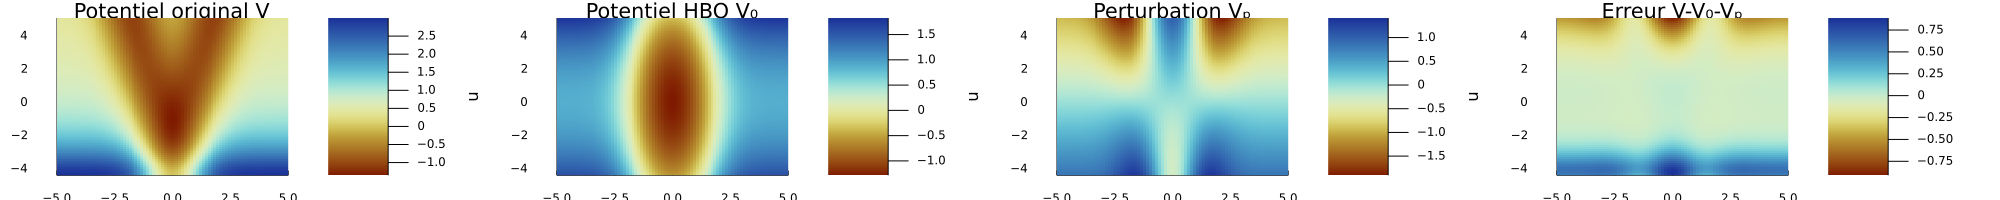

In [161]:
plot_V   = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel original V", grid=true, aspect_ratio=:auto ) 
plot_V₀  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), V₀', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Potentiel HBO V₀", aspect_ratio=:auto )
plot_Vp  = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N), Vp', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Perturbation Vₚ", aspect_ratio=:auto )
plot_dif = heatmap(LinRange(r_min,r_max,N),LinRange(u_min,u_max,N),(V-V₀-Vp)', xlabel="r", ylabel="u", xlims = (r_min,r_max), ylims=(u_min,u_max), color=cgrad(:roma, rev=false), title = "Erreur V-V₀-Vₚ", aspect_ratio=:auto ) # , clims=(-1000.,0.)
plot(plot_V, plot_V₀, plot_Vp, plot_dif, layout = (1, 4), legend = false, size=(2000,200), down_margin = 10Plots.mm)

### 3) Calcul 2D (triché) de l'état fondamental du hamiltonien original $Ĥ$

  0.175612 seconds (9.35 k allocations: 91.697 MiB, 10.16% gc time)


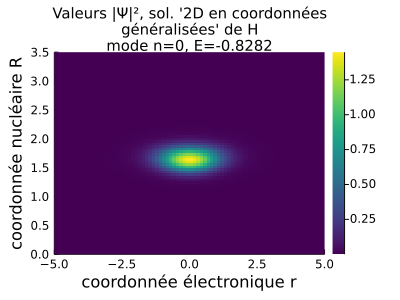

In [175]:
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ, N*N, 2, :SR, krylovdim=40);
@assert info.converged ≥ 1;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕH = lϕ[mode_numérique+1];
ϕH_p = densité*Matrix(transpose(reshape(ϕH.^2,N,N)));
heatmap(rs, Rs, ϕH_p,
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

  0.166800 seconds (9.55 k allocations: 93.682 MiB, 7.90% gc time)
  0.269415 seconds (5.11 k allocations: 2.468 MiB)


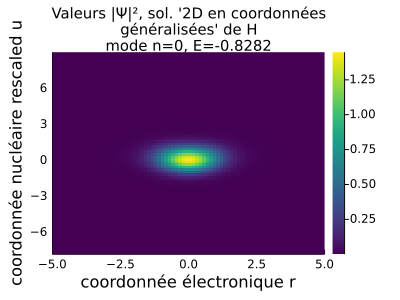

In [176]:
using Arpack

@time lE, lϕ, info = KrylovKit.eigsolve(𝔥, N*N, 2, :SR, krylovdim=40);
# @assert info.converged ≥ 1
@time E_arpack, ϕ_arpack = Arpack.eigs(𝔥, nev=1, ncv=40, which=:SR, tol=1e-16, maxiter=1000, sigma=nothing, ritzvec=true, v0=zeros((0,)));

mode_numérique = 0; 
densité = 1/ϵ*N^2/(u_max-u_min)/(r_max-r_min);
ϕH = lϕ[mode_numérique+1];
ϕH = ϕ_arpack;
ϕH_p = Matrix(transpose(reshape(ϕH.^2,N,N)));
heatmap(rs, us, densité*ϕH_p,
    xlims = (r_min,r_max),
    ylims = (u_min,u_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire rescaled u",
    title = "Valeurs |Ψ|², sol. '2D en coordonnées\ngénéralisées' de H\nmode n=$mode_numérique, E=$(round(E_arpack[1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    color=:viridis,
    right_margin = 7Plots.mm,
    up_margin = 3Plots.mm)

In [169]:
𝔥 ≈ Ĥ

true

### 3) Calcul 2D (triché) de l'état fondamental du hamiltonien perturbé $Ĥ⁰+ \lambda Ŵ (\neq Ĥ)$

  0.126269 seconds (12.73 k allocations: 100.343 MiB, 13.01% gc time)
info.converged = 0


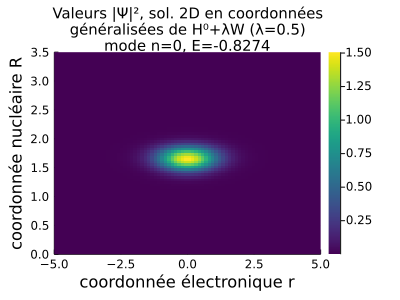

In [177]:
λ = .5;
@time lE, lϕ, info = KrylovKit.eigsolve(Ĥ⁰+λ*Ŵ, N*N, 2, :SR, krylovdim=20); # 𝔥+λ*Ŵ
@show info.converged;
mode_numérique = 0; 
densité = N^2/(R_max-R_min)/(r_max-r_min);
ϕHλW = lϕ[mode_numérique+1];
ϕHλW_p = densité*Matrix(transpose(reshape(ϕHλW.^2,N,N)));
heatmap(rs, Rs, ϕHλW_p,
    xlims = (r_min,r_max),
    ylims = (R_min,R_max),
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    color=:viridis,
    title = "Valeurs |Ψ|², sol. 2D en coordonnées\ngénéralisées de H⁰+λW (λ=$λ)\nmode n=$mode_numérique, E=$(round(lE[mode_numérique+1],digits=4))",
    aspect_ratio=:auto,
    titlefontsize=10,
    size=(400,300),
    right_margin = 8Plots.mm,
    up_margin = 3Plots.mm)

### 4) Calcul Axe $(Ox)$ des plus petits éléments propres (états + énergies) du hamiltonien électronique  $H_r$
On utilise une méthode itérative (Krylov), on ne calcule que les les plus petites énergies

  0.001631 seconds (1.21 k allocations: 378.328 KiB)
infos.converged = 5


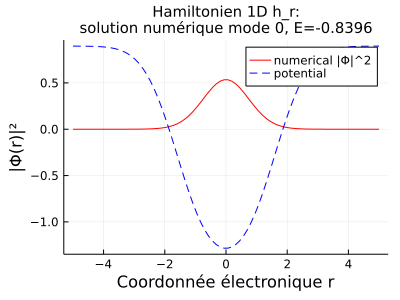

In [178]:
nb_modes_x = 5;
@time lE⁰x, lϕ⁰x, infos = KrylovKit.eigsolve(Ĥ⁰r, N, nb_modes_x, :SR, krylovdim=30);
@show infos.converged
nx = 0; densité_x = N/(r_max-r_min);
plot(rs,
    [densité_x*abs.(lϕ⁰x[nx+1]).^2, V₀r],
    grid=true,
    w=[1 1],
    color = ["red" "blue"],
    linestyle=[:solid :dash],
    xlabel="Coordonnée électronique r",ylabel="|Φ(r)|²",
    label=["numerical |Φ|^2" "potential"],
    title = "Hamiltonien 1D h_r:\nsolution numérique mode $nx, E=$(round(lE⁰x[nx+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

  0.002255 seconds (1.41 k allocations: 386.516 KiB)
info.converged = 2


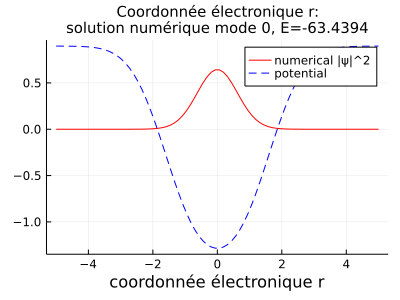

In [124]:
@time lE, lϕ, info = KrylovKit.eigsolve(𝔥r, N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 

nr = 0; densité_r = N/(r_max-r_min);
plot(rs,
    [densité_r*abs.(lϕ[nr+1]).^2, V₀r],
    grid=true,
    w=[1 1],
    color = ["red" "blue"],
    linestyle=[:solid :dash],
    xlabel="coordonnée électronique r",
    label=["numerical |ψ|^2" "potential"],
    title = "Coordonnée électronique r:\nsolution numérique mode $nr, E=$(round(lE[nr+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 5) Calcul Axe $(Oy)$ des plus petits éléments propres (états + énergies) du hamiltonien nucléaire $H_R$

In [179]:
using Polynomials, SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [SpecialPolynomials.basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1Dω = (n,x,m,ω) -> (m*ω)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](sqrt(m*ω)*x)*exp(-m*ω/2*x^2);
ϕ1Dk = (n,x,m,k) -> (k*m)^(.125)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1]((k*m)^(.25)*x)*exp(-sqrt(k*m)/2*x^2);
ϕ1Du = (n,u,m,k) -> (k*m)^(.125)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](u)*exp(-1/2*u^2); # u tel que r = ϵu

  0.001259 seconds (1.10 k allocations: 286.094 KiB)
infos.converged = 5


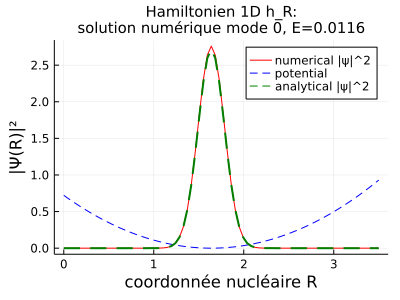

In [180]:
nb_modes_y = 5;
@time lE⁰y, lϕ⁰y, infos = KrylovKit.eigsolve(Ĥ⁰R, N, nb_modes_y, :SR, krylovdim=20);
@show infos.converged
ny = 0; densité_y = N/(R_max-R_min);
sol_analytique_y = [ϕ1Dk(ny,y-R₀,M,K) for y in Rs];
plot(Rs,
    [densité_y*abs.(lϕ⁰y[ny+1]).^2, V₀R, sol_analytique_y.^2],
    grid=true, w=[1 1 2],
    color = ["red" "blue" "green"],
    xlabel="coordonnée nucléaire R",ylabel="|Ψ(R)|²",
    linestyle=[:solid :dash :dash],
    label=["numerical |ψ|^2" "potential" "analytical |ψ|^2"],
    title = "Hamiltonien 1D h_R:\nsolution numérique mode $ny, E=$(round(lE⁰y[ny+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

  0.001197 seconds (918 allocations: 247.547 KiB)
info.converged = 3


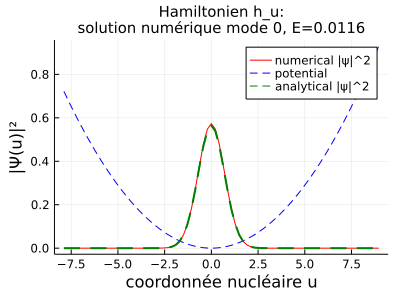

In [181]:
@time lE⁰u, lϕ⁰u, info = KrylovKit.eigsolve(𝔥u, N, 2, :SR, krylovdim=20);
@show info.converged;
mode_numérique = 0; 

nu = 0; densité_u = N/(u_max-u_min);
sol_analytique_u = [sqrt(ϵ)*ϕ1Du(nu,u,M,K) for u in us];
plot(us,
    [densité_u*abs.(lϕ⁰u[nu+1]).^2, V₀R, sol_analytique_u.^2],
    grid=true,
    w=[1 1 2],
    color = ["red" "blue" "green"],
    linestyle=[:solid :dash :dash],
    xlabel="coordonnée nucléaire u",ylabel="|Ψ(u)|²",
    label=["numerical |ψ|^2" "potential" "analytical |ψ|^2"],
    title = "Hamiltonien h_u:\nsolution numérique mode $nu, E=$(round(lE⁰u[nu+1], digits=4))",
    titlefontsize=10,
    size=(400,300))

### 6) Calcul de la solution-produit séparable du hamiltonien non perturbé $H_{HBO}$

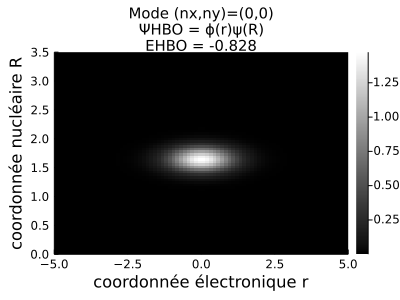

In [182]:
nxc = 0; nyc = 0;
ΨHBO_v = lϕ⁰x[nxc+1] * lϕ⁰y[nyc+1]'; # normé car les deux le sont
ΨHBO = reshape(ΨHBO_v,N*N)
EHBO = lE⁰x[nxc+1] + lE⁰y[nyc+1];
densité = N^2/(R_max-R_min)/(r_max-r_min);
heatmap(rs, Rs, densité*ΨHBO_v'.^2,
    color=:greys,
    aspect_ratio=:auto,
    xlim=[r_min,r_max], ylim=[R_min, R_max],
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire R",
    size=(400,300),
    titlefontsize=10,
    title = "Mode (nx,ny)=($nxc,$nyc)\nΨHBO = ϕ(r)ψ(R)\nEHBO = $(round(EHBO,digits=4))")

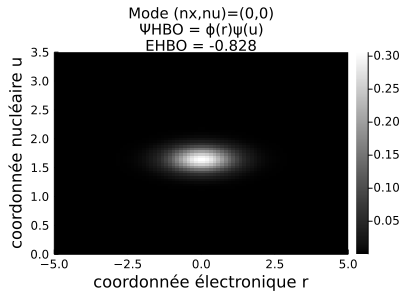

In [100]:
nxc = 0; nyc = 0;
ΨHBO_u = lϕ⁰x[nxc+1] * lϕ⁰u[nu+1]'; # normé car les deux le sont
ΨHBO_u = reshape(ΨHBO_u,N*N)
EHBO = lE⁰x[nxc+1] + lE⁰u[nu+1];
densité = N^2/(u_max-u_min)/(r_max-r_min);
heatmap(rs, Rs, densité*ΨHBO_u'.^2,
    color=:greys,
    aspect_ratio=:auto,
    xlim=[r_min,r_max], ylim=[R_min, R_max],
    xlabel="coordonnée électronique r",
    ylabel="coordonnée nucléaire u",
    size=(400,300),
    titlefontsize=10,
    title = "Mode (nx,nu)=($nxc,$nyc)\nΨHBO = ϕ(r)ψ(u)\nEHBO = $(round(EHBO,digits=4))")

## Théorie des perturbations, CPU

In [101]:
using IterativeSolvers
using LinearAlgebra
using LinearMaps


Ψ₀ = copy(ΨHBO_u);
W =  copy(Ŵu); # W: sparse
H₀ = copy(𝔥₀); # sparse
E₀ = EHBO;

Qmax   = 3;

proj = x -> dot(Ψ₀,x)*Ψ₀; # on gagne ~1 prdre de grandeur en temps en utilisant dot au lieu du produit matriciel Ψ₀*(Ψ₀'*x)
Π_ort  = LinearMap(x -> x - proj(x), N*N); # ne pas assembler
Π_par  = LinearMap(x -> proj(x), N*N);



P_ort  = LinearMap(x -> Π_ort(H₀*Π_ort(x)-E₀*Π_ort(x)), N*N); # Π⟂(H₀-E₀)Π⟂
P_par  = LinearMap(x -> Π_par(H₀*Π_par(x)-E₀*Π_par(x)), N*N); # Π∥(H₀-E₀)Π∥


llΨ    = zeros(Float64, N*N, Qmax); # création liste des termes d'énergie   en fonction de l'ordre q
llE    = zeros(Float64, Qmax);      # création liste des termes de vecteurs en fonction de l'ordre q

Wl     = LinearMap(x -> W*x, N*N);


b      = -Π_ort(W*Ψ₀); # -Π⟂WΨ₀ dans 3.63


# GC ordre 1 et sauvegarde
llΨ[:,1] = cg(P_ort, b);

llE[1]    = Ψ₀'*Wl(Ψ₀); # terme d'énergie à l'ordre 1


WlmE₁ = LinearMap(x -> W*x-llE[1]*x, N*N);


R_ort  = -Π_ort*WlmE₁;
R_par  = -Π_par*WlmE₁;

acc_b   = zeros(N*N);
acc_ort = zeros(N*N);
acc_par = zeros(N*N);

for q ∈ 2:Qmax
    # calcul énergie ordre q
    llE[q] = Ψ₀'*WlmE₁(llΨ[:,q-1]); # premier terme de 3.65

    for i ∈ 1:(q-2)
        llE[q] = llE[q] - llE[q-i]* Ψ₀'*llΨ[:,i]; # somme du second terme dans 3.65
    end

    # calcul état ordre q
    fill!(acc_b, 0.);
    @views acc_ort[:] = llE[q]*Ψ₀; # dernier terme de la somme de LHS dans 3.66 à i=0
    @views acc_par[:] = llE[q]*Ψ₀; # dernier terme de la somme de LHS dans 3.67 à i=0

    for i ∈ 1:(q-2)
        @. acc_ort[:] = acc_ort + llE[q-i]*llΨ[i] # autres termes de la somme dans LHS de 3.66
        @. acc_par[:] = acc_par + llE[q-i]*llΨ[i] # autres termes de la somme dans LHS de 3.67
    end
    acc_ort[:] = -Π_ort(WlmE₁(llΨ[:,q-1])) + Π_ort(acc_ort); # LHS de 3.66
    acc_par[:] = -Π_ort(WlmE₁(llΨ[:,q-1])) + Π_ort(acc_par); # LHS de 3.66
    

    acc_ort[:] = cg(P_ort, acc_ort);
    acc_par[:] = cg(P_par, acc_par)
    llΨ[:,q] = Array(acc_ort + acc_ort);
end



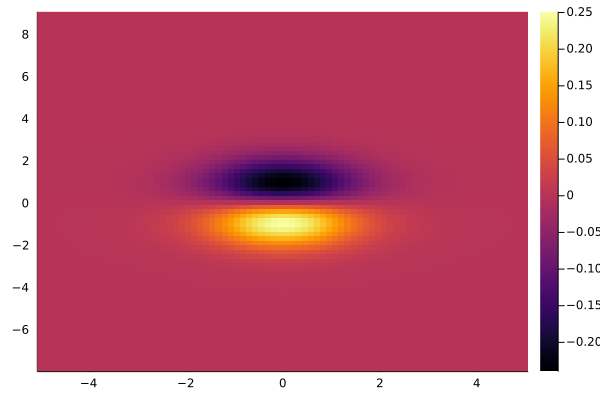

In [109]:
heatmap(rs, us, reshape(llΨ[:,1], N, N)')

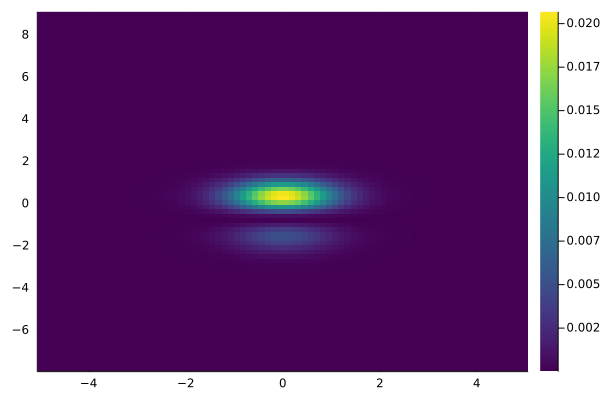

In [114]:
Ψ1 = ΨHBO + ϵ*llΨ[:,1];
Ψ2 = ΨHBO + ϵ*llΨ[:,1] + ϵ^2*llΨ[:,2];
heatmap(rs, us, reshape(Ψ2.^2, N, N)', color=:viridis)

In [116]:
norm(Ψ1 - ΨHBO), norm(Ψ2 - ΨHBO)

(0.6605906121585013, 1.0283448066990404)

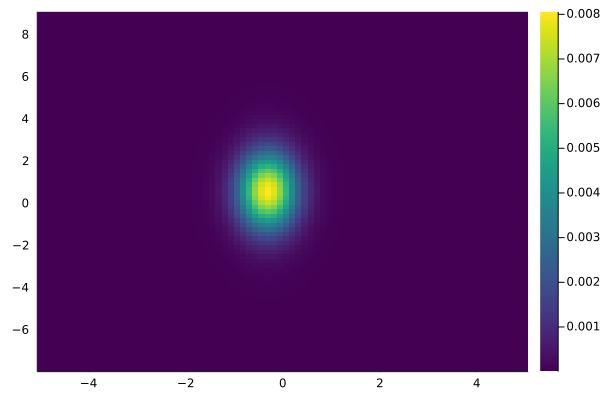

In [108]:
heatmap(rs, us, reshape(ΨHBO, N, N).^2, color=:viridis)

In [44]:
llE[:,1]

3-element Vector{Float64}:
  0.002176190508862143
 -0.0020827510654341562
  0.0008393239049772803

In [25]:
Ψ₀ = copy(ΨHBO_u);
W =  copy(Ŵ); # W: sparse
H₀ = copy(𝔥); # sparse
E₀ = EHBO;

size(ΨHBO_u), size(Ŵ), size(𝔥), typeof(ΨHBO_u), typeof(Ŵ), typeof(𝔥)


((6400,), (6400, 6400), (6400, 6400), Vector{Float64}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Float64, Int64})

In [28]:
typeof(Ψ₀), typeof(W), typeof(H₀)

(Vector{Float64}, Diagonal{Float64, Vector{Float64}}, SparseMatrixCSC{Float64, Int64})

In [87]:
Ψ_sol = copy(Ψ₀);
for i in 1:Qmax
    @views Ψ_sol[:] = Ψ_sol + llΨ[:,i]
end

1000-element Vector{Float64}:
  2.2730197919207516e18
  1.6639415017272294e18
  6.046414727227094e17
  1.627485386892047e18
  4.1641958306064506e17
  6.249926236996804e17
  2.618696600683088e17
 -1.2747284455098263e18
 -1.3151038500694825e19
  2.2707525499790597e18
  ⋮
  9.560849217681838e17
  2.844698717738471e18
 -1.6503522047531715e18
  9.167782246730852e17
  1.6241362017640755e18
  3.7501072959691827e18
  2.1135775013402384e17
  4.06690649961813e17
  2.438309758169199e18